# Conceptor Action with multi-patterns!

In [22]:
from matplotlib import pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize']=(8.0,6.0)
mpl.rcParams['font.size']=14

import numpy as np

import functions

np.random.seed(1)

## Network Setup

In [23]:
# network size
N = 100

# network connectivity
netConn = 10./N

# initialize random weights
W_unscaled = functions.sprandn(N,N,netConn)
specRad = functions.getSpecRad(W_unscaled)
W_raw = W_unscaled/specRad * 1.5

# initialize input matrix
netInputScaling = 1.7
numInputDims = 1
W_in = netInputScaling * np.random.normal(0,1,(N,numInputDims))

#initialize bias matrix
biasScaling = 0.2
W_bias = biasScaling * np.random.normal(0,1,(N,1))

# Patterns

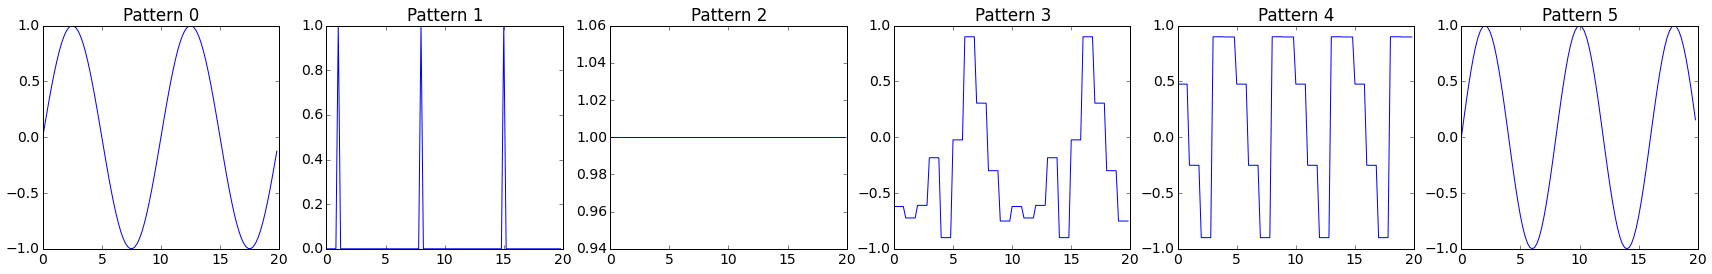

In [24]:
from pattCat import getPatterns

patts = getPatterns()

pattern_idxs = [1, 6, 8, 18, 36, 42]
patterns = [patts[i] for i in pattern_idxs]
n_patterns = len(patterns)

# PLOTTING ALL
plotAllPatterns = False
if plotAllPatterns :
    cols = 10
    rows = int(len(patts)/cols + 1)
    plt.figure(figsize=(5*cols, 4*rows));
    x_vals = np.arange(0,20,0.2)
    for i, patt in enumerate(patts):
        plt.subplot(rows, cols, i+1).set_title("Pattern {}".format(i));
        plt.plot(x_vals, [patt(x) for x in x_vals], 'b');

# PLOTTING SELECTED
cols = 10
rows = int(len(patterns)/cols + 1)
plt.figure(figsize=(5*cols, 4*rows));
x_vals = np.arange(0,20,0.2)
for i, patt in enumerate(patterns):
    plt.subplot(rows, cols, i+1).set_title("Pattern {}".format(i));
    plt.plot(x_vals, [patt(x) for x in x_vals], 'b');

## Harvesting

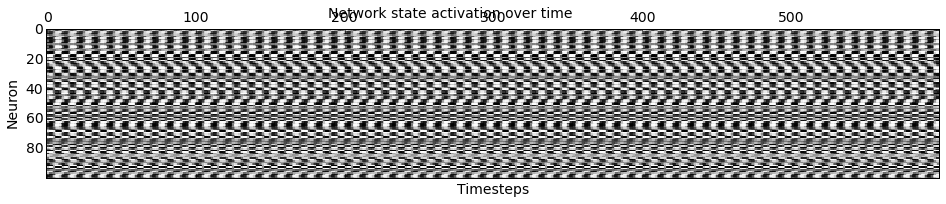

In [25]:
washoutTimesteps = 500
learnTimesteps = 1000

# init empty state
x = np.zeros((N, 1))

stateCollector = np.zeros((N, learnTimesteps*n_patterns))
inputCollector = np.zeros((numInputDims, learnTimesteps*n_patterns))

for i_pat, pat in enumerate(patterns):
    for t in xrange(washoutTimesteps + learnTimesteps):
        # get input from pattern-function
        u = np.asarray(pat(t))

        # update rule
        x = np.tanh(np.dot(W_raw, x) + np.dot(W_in, u) + W_bias)

        # if we are over the washout period, we start saving states
        if t >= washoutTimesteps:
            # we need to transpose x and u,
            # because accessing a row OR column in a numpy matrix always resturns a row vector
            offset = i_pat*learnTimesteps
            stateCollector[:, offset + t - washoutTimesteps] = x.T
            inputCollector[:, offset + t - washoutTimesteps] = u.T
        
# show the states over time
plt.matshow(stateCollector[:,0:600], cmap=plt.cm.gray);
plt.suptitle("Network state activation over time");
plt.xlabel("Timesteps");
plt.ylabel("Neuron");

## Train Output Matrix

In [26]:
W_out = functions.ridgeRegression(
    A = stateCollector.T,
    b = inputCollector.T,
    alpha = 0.01)

## Test Output Training

NRMSE Readout: [ 0.00489014]


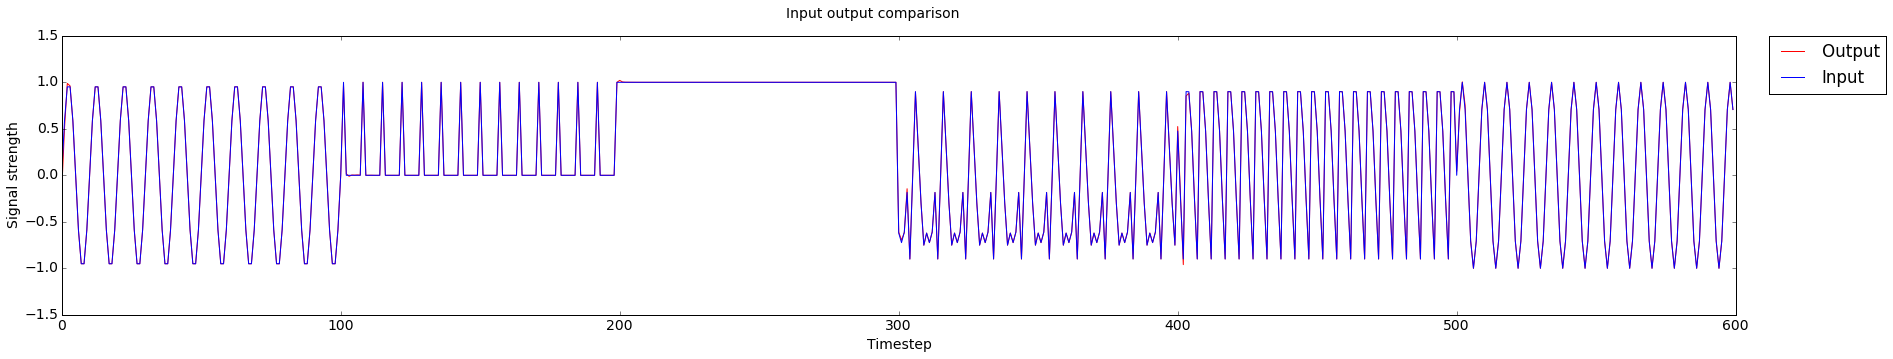

In [27]:
testTimesteps = 100

# continue with last state
x = 0.5*np.random.randn(N, 1)

testOutputCollector = np.zeros((numInputDims, testTimesteps*n_patterns))
testInputCollector = np.zeros((numInputDims, testTimesteps*n_patterns))

for i_pat, pat in enumerate(patterns):
    for t in xrange(testTimesteps):
        # get input from pattern-function after washout and learning phase
        # this means we just continue after this phase
        u = np.asarray(pat(t))

        # update rule
        x = np.tanh(np.dot(W_raw, x) + np.dot(W_in, u) + W_bias)

        # start computing outputs
        output = np.dot(x.T, W_out)
        offset = i_pat*testTimesteps
        testOutputCollector[:, offset + t] = output.T
        testInputCollector[:, offset + t] = u.T

plt.figure(figsize=(30,5));
plt.plot(testOutputCollector[0,:], 'r', label="Output");
plt.plot(testInputCollector[0,:], 'b', label="Input");
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.);
plt.suptitle("Input output comparison");
plt.xlabel("Timestep");
plt.ylabel("Signal strength");

print 'NRMSE Readout: {}'.format(functions.NRMSE(testOutputCollector, testInputCollector))

## Loading

Spec Rad of the loaded weight matrix 138.695956803
mean NRMSE W: 0.0127290949435


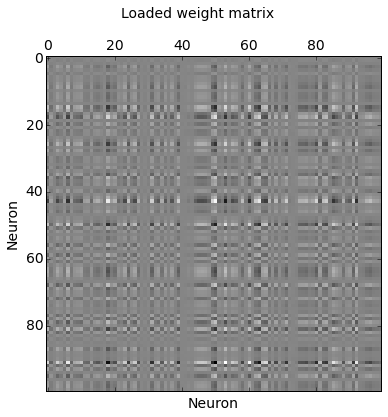

In [28]:
stateCollectorOld = np.zeros((N, learnTimesteps*n_patterns))
stateCollectorOld[:,1:] = stateCollector[:,0:-1]

target = np.arctanh(stateCollector) - np.tile(W_bias, (1, learnTimesteps*n_patterns))

W_loaded = functions.ridgeRegression(stateCollectorOld.T, target.T, 0.1).T

loadSpecRad = functions.getSpecRad(W_loaded)
print 'Spec Rad of the loaded weight matrix ' + str(loadSpecRad)

# training error per neuron
nrmse_loading = functions.NRMSE(np.dot(W_loaded, stateCollectorOld), target)
print 'mean NRMSE W: ' + str(np.mean(nrmse_loading))


plt.matshow(W_loaded, cmap=plt.cm.gray);
plt.suptitle("Loaded weight matrix");
plt.xlabel("Neuron");
plt.ylabel("Neuron");

## Test Loading Without Conceptors

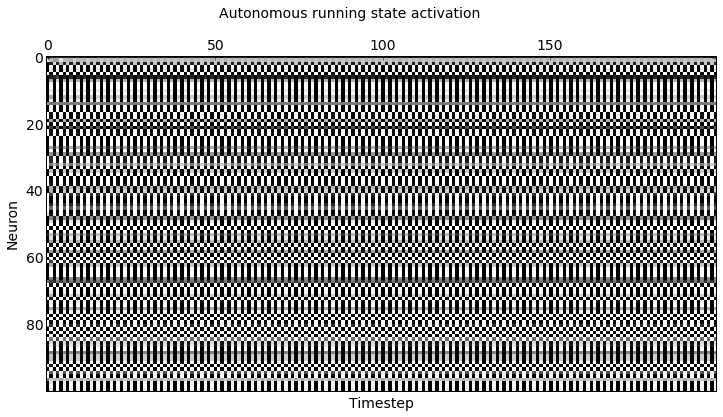

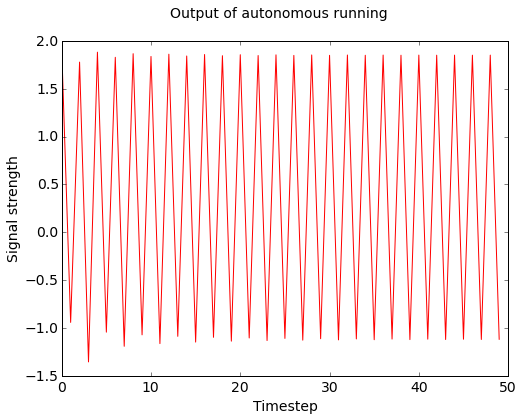

In [29]:
loadingTestTimesteps = 200

# init random state
x = 0.5*np.random.randn(N, 1)

loadingTestOutputCollector = np.zeros((numInputDims, loadingTestTimesteps))
loadingTestStateCollector = np.zeros((N, loadingTestTimesteps))

for t in xrange(loadingTestTimesteps):
    
    # update rule
    x = np.tanh(np.dot(W_loaded, x) + W_bias)
    
    loadingTestStateCollector[:, t] = x.T
    
    output = np.dot(x.T, W_out)
    loadingTestOutputCollector[:, t] = output.T



plt.matshow(loadingTestStateCollector[:,:], cmap=plt.cm.gray);
plt.suptitle("Autonomous running state activation");
plt.xlabel("Timestep");
plt.ylabel("Neuron");

plt.figure();
plt.plot(loadingTestOutputCollector[0,:50], 'r');
plt.suptitle("Output of autonomous running");
plt.xlabel("Timestep");
plt.ylabel("Signal strength");

## Conceptors

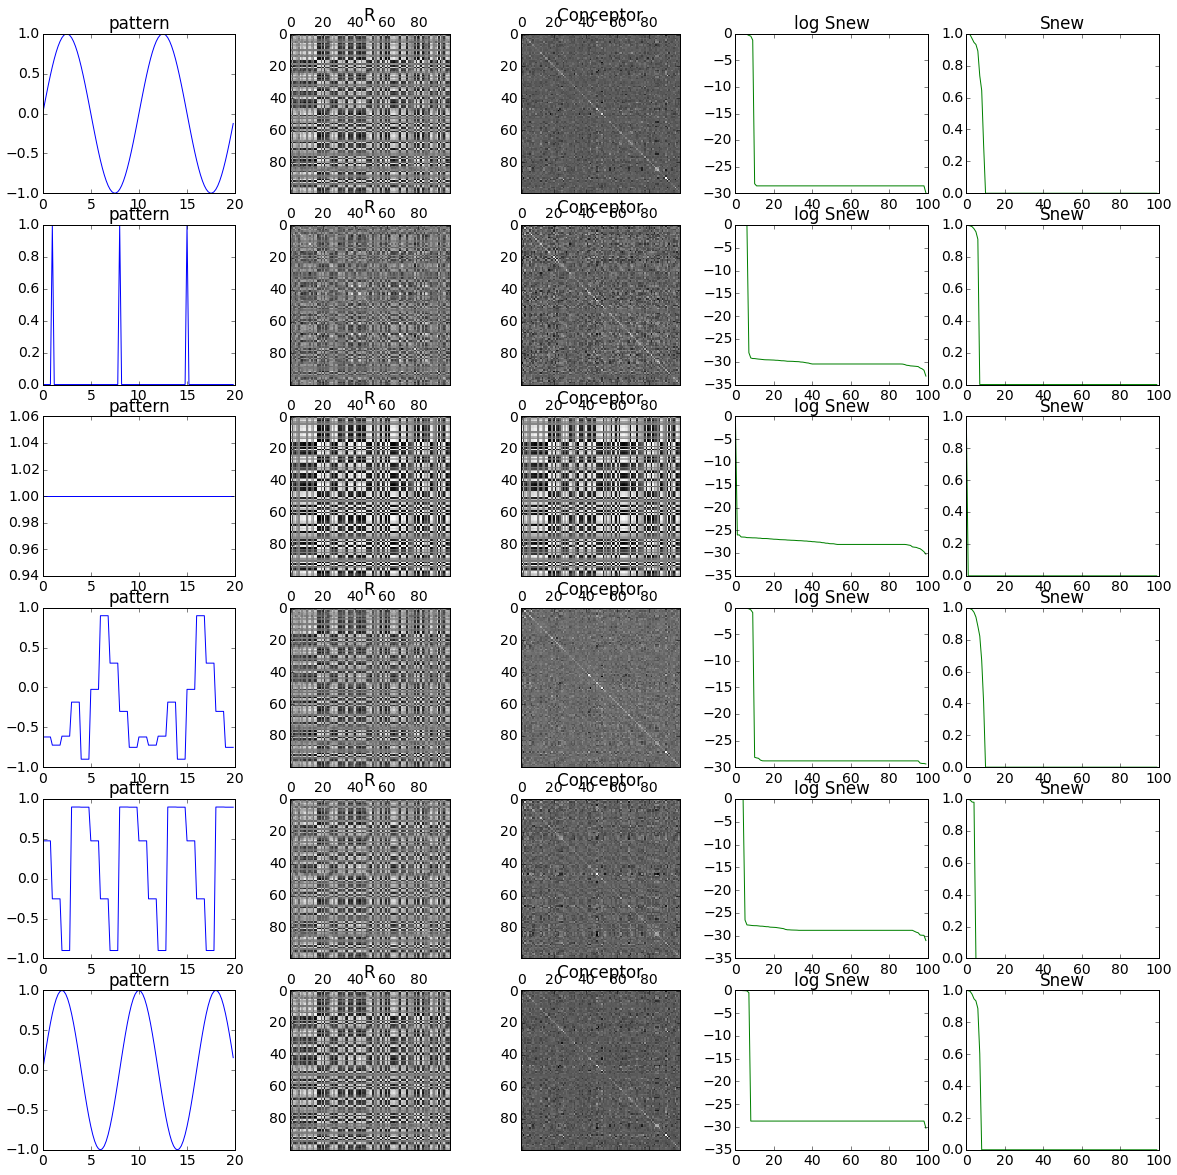

In [30]:
conceptors = []
plt.figure(figsize=(20,20));
for i_pat, pat in enumerate(patterns):
    offset = i_pat*learnTimesteps
    states = stateCollector[:, offset:offset+learnTimesteps]
    
    R = np.dot(states, states.T) / learnTimesteps
    U,S,V = np.linalg.svd(R, full_matrices=True)
    S = np.diag(S)
    
    alpha = 10
    I = np.eye(N)
    Snew = (np.dot(S,np.linalg.inv(S + (alpha**-2)*I)))
    C = np.dot(U,np.dot(Snew,V))
    conceptors.append(C)
    
    cols = 5
    
    plt.subplot(n_patterns, cols, i_pat*cols + 1).set_title("pattern");
    plt.plot(x_vals, [pat(x) for x in x_vals], 'b');
    
    ax = plt.subplot(n_patterns, cols, i_pat*cols + 2);
    ax.set_title("R")
    ax.matshow(R, cmap=plt.cm.gray);
    
    ax = plt.subplot(n_patterns, cols, i_pat*cols + 3);
    ax.set_title("Conceptor")
    ax.matshow(C, cmap=plt.cm.gray);
    
    plt.subplot(n_patterns, cols, i_pat*cols + 4).set_title("log Snew");
    plt.plot(np.log(np.diagonal(Snew)), 'g');
    
    plt.subplot(n_patterns, cols, i_pat*cols + 5).set_title("Snew");
    plt.plot(np.diagonal(Snew), 'g');


## Test Loading With Conceptors

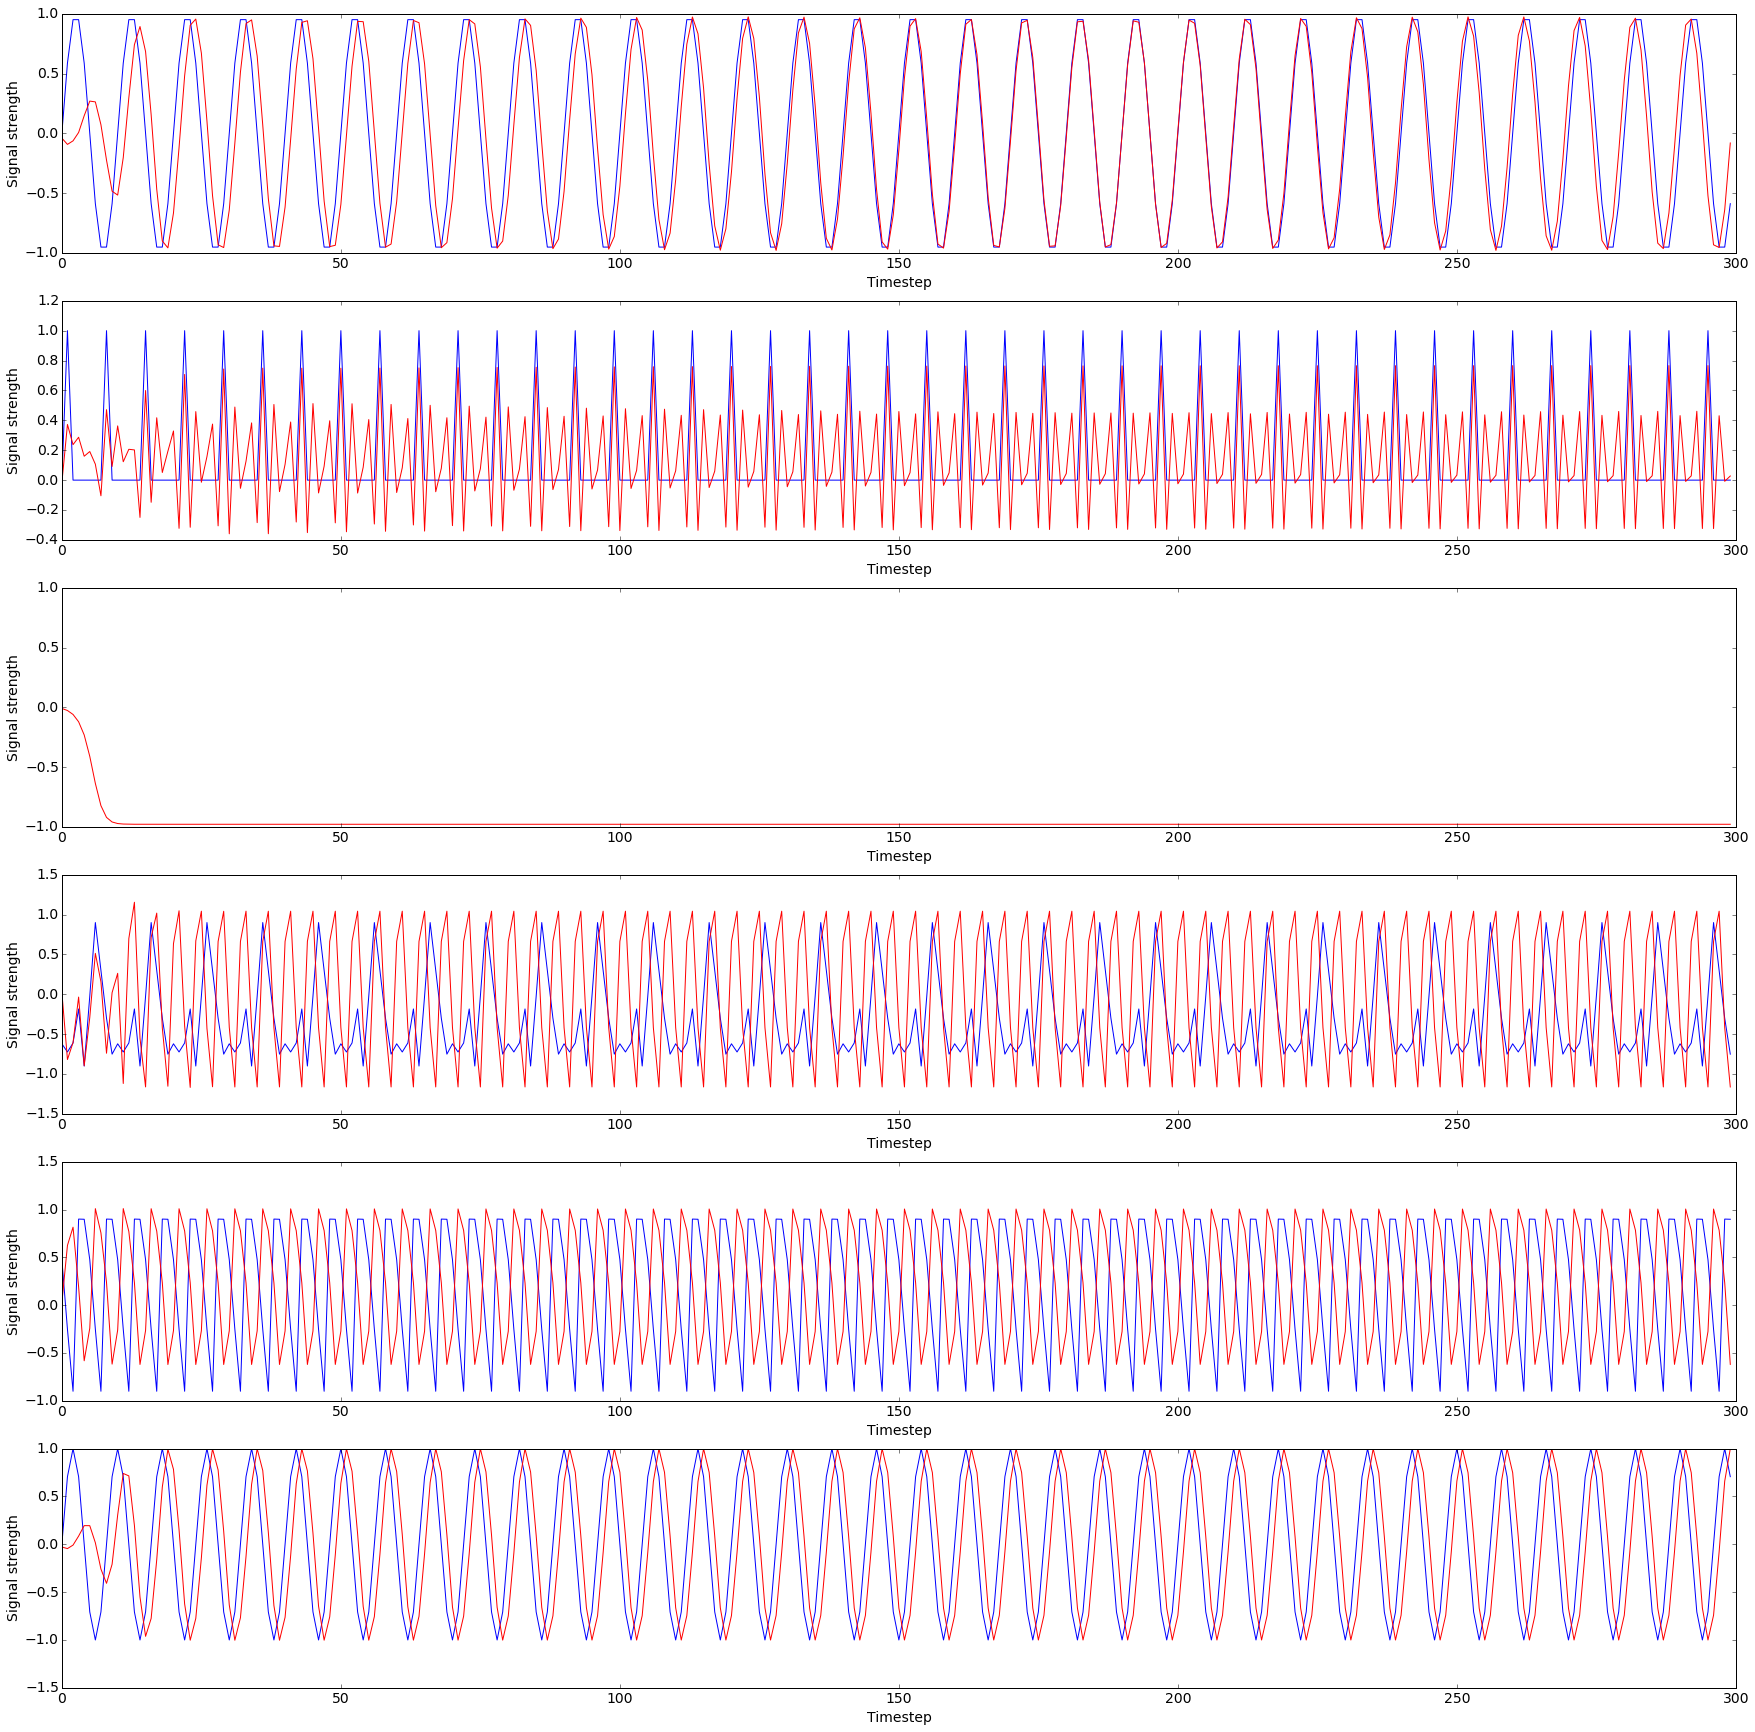

In [31]:
loadingTestTimesteps = 300

plt.figure(figsize=(30,5*n_patterns));
for i_pat, pat in enumerate(patterns):
    
    # init random state
    x = np.zeros((N, 1))

    loadingTestOutputCollector = np.zeros((numInputDims, loadingTestTimesteps))
    loadingTestStateCollector = np.zeros((N, loadingTestTimesteps))
    
    for t in xrange(loadingTestTimesteps):

        # update rule
        x = np.tanh(np.dot(W_loaded, x) + W_bias)

        # Apply the Concepor
        x = np.dot(conceptors[i_pat],x)

        loadingTestStateCollector[:, t] = x.T

        output = np.dot(x.T, W_out)
        loadingTestOutputCollector[:, t] = output.T

    cols = 1
    
    plt.subplot(n_patterns, cols, i_pat*cols + 1);
    plt.plot([pat(x) for x in xrange(300)], 'b');
    
    #plt.subplot(n_patterns, cols, i_pat*cols + 2);
    plt.plot(loadingTestOutputCollector[0,0:300], 'r');
    plt.xlabel("Timestep");
    plt.ylabel("Signal strength");